In [2]:
import datetime
import time
import requests
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from config import get_from_config, save_to_config
from acnet_reader.acnet_reader import fetch_data, get_interpolated_df, fetch_interpolated_data
import fur.path_assistant as path_assistant
plt.rcParams['figure.figsize'] = [20, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
shift_03_10_2020 = path_assistant.PathAssistant('shift_03_10_2020')
waveforms_dir = shift_03_10_2020.get_waveforms_dir()
results_dir = shift_03_10_2020.get_results_dir()
acnet_data_dir = shift_03_10_2020.get_acnet_data_dir()
bpm_data_dir = shift_03_10_2020.get_bpm_data_dir()
bpm_files_df = shift_03_10_2020.get_bpm_files_df()
acnet_data_df = shift_03_10_2020.get_acnet_data_df("all_acnet_data_03_10_2020.csv")
fluctuations_df = shift_03_10_2020.get_fluctuations_df("res_df_nd_filters_data_03_10_2020.csv")


/home/ilobach/fur


From memory, the time stamp on the bunch profile monitor waveforms whould be close to the actual time when the fluctuations waveform was taken. Not sure about the time stamp on the fluctuaitons waveform file. Should be close, but could be wrong for a few seconds.

In [3]:
iwcm_to_wbeam = get_from_config("IWCMI_to_IBEAMA")
iwcmi0 = -3.040

In [4]:
fluctuations_df.sort_values("file_datetime")
bpm_files_df.sort_values("file_datetime")
RS_scope_behind = np.mean(bpm_files_df["file_datetime"]-fluctuations_df["file_datetime"])
print("R&S scope's time is behind by {}".format(RS_scope_behind))

R&S scope's time is behind by 0 days 00:00:20.575844


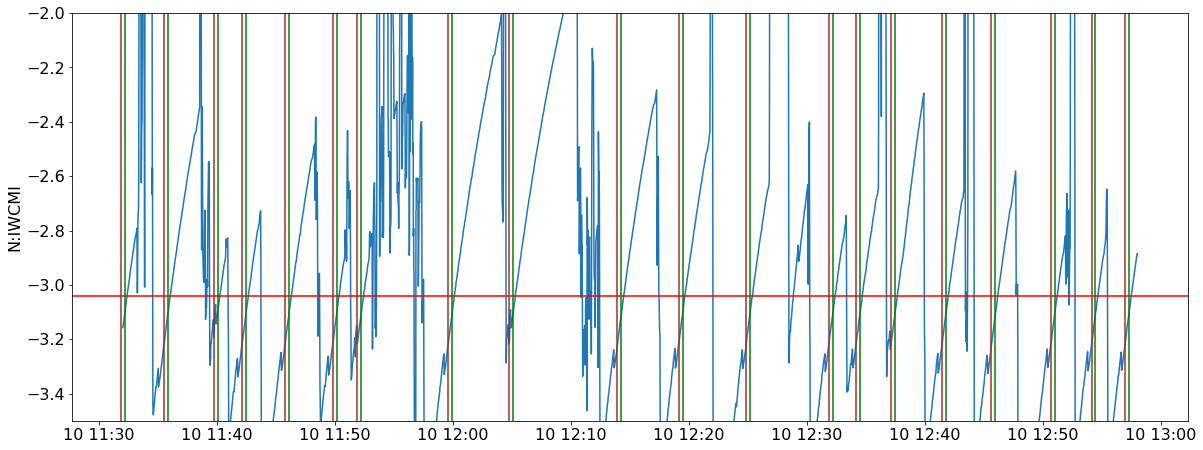

In [5]:
ax = sns.lineplot(x=acnet_data_df.index, y=acnet_data_df["N:IWCMI"])
ax.set_ylim(-3.5, -2.0)
plt.axhline(iwcmi0, color="red")
for t in fluctuations_df["file_datetime"]:
    plt.axvline(t, color="brown")
for t in bpm_files_df["file_datetime"]:
    plt.axvline(t, color="green")
plt.show()

In [6]:
fluctuations_df["rounded_bpm_file_datetime"] = bpm_files_df["file_datetime"].apply(lambda t: t.round(freq='S'))

In [7]:
fluctuations_df.head()

,waveform_file,ch2_amplitude,var_of_ch1_amplitude,noise_var,file_datetime,rounded_bpm_file_datetime
0,RefCurve_2020-03-10_10_121356.Wfm.bin,0.330091,1.772649e-08,8.758951e-08,2020-03-10 12:13:56,2020-03-10 11:32:12
1,RefCurve_2020-03-10_11_121907.Wfm.bin,0.330524,1.762733e-08,8.764901e-08,2020-03-10 12:19:07,2020-03-10 11:35:51
2,RefCurve_2020-03-10_12_122451.Wfm.bin,0.275669,1.260910e-08,8.668348e-08,2020-03-10 12:24:51,2020-03-10 11:40:03
3,RefCurve_2020-03-10_13_123150.Wfm.bin,0.276897,1.380884e-08,8.724680e-08,2020-03-10 12:31:50,2020-03-10 11:42:27
4,RefCurve_2020-03-10_14_123409.Wfm.bin,0.276813,1.289925e-08,8.696409e-08,2020-03-10 12:34:09,2020-03-10 11:46:06


In [8]:
cameras = ["N:ITC1RSV", "N:ITC1RSH",
           "N:ITC2RSV", "N:ITC2RSH",
           "N:ITC3RSV", "N:ITC3RSH",
           "N:ITC4RSV", "N:ITC4RSH",
           "N:ITC4LSV", "N:ITC4LSH",
           "N:ITC3LSV", "N:ITC3LSH",
           "N:ITC2LSV", "N:ITC2LSH",
           "N:ITC1LSV", "N:ITC1LSH"]

In [9]:
acnet_addition = acnet_data_df.loc[acnet_data_df.index.isin(fluctuations_df["rounded_bpm_file_datetime"])].loc[:,["N:IWCMI","N:IBEAMA","N:IWCMBE"]+cameras]

In [10]:
fluctuations_df = pd.concat([fluctuations_df, acnet_addition.reset_index(drop=True)], axis=1)

In [11]:
bunch_params_des = fluctuations_df.describe().iloc[:,3:]
bunch_params_des

,N:IWCMI,N:IBEAMA,N:IWCMBE,N:ITC1RSV,N:ITC1RSH,N:ITC2RSV,N:ITC2RSH,N:ITC3RSV,N:ITC3RSH,N:ITC4RSV,N:ITC4RSH,N:ITC4LSV,N:ITC4LSH,N:ITC3LSV,N:ITC3LSH,N:ITC2LSV,N:ITC2LSH,N:ITC1LSV,N:ITC1LSH
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-3.100662,-2.833189,29.519271,118.631071,482.364166,82.437101,1455.804900,98.769470,1681.260265,105.9989,7.327710e+02,166.789298,1104.937873,76.189315,1686.856890,73.051287,1594.700080,141.268839,515.091194
std,0.005299,0.019656,0.223206,2.930029,5.371180,0.534233,17.146477,1.224057,19.141586,0.0000,1.166402e-13,2.597575,12.274406,1.588730,20.367509,0.702890,17.618876,3.680457,5.789780
min,-3.108926,-2.872040,29.250820,112.151400,474.122360,81.333500,1431.053000,95.904553,1654.111500,105.9989,7.327710e+02,161.117400,1087.159550,72.665100,1651.745500,71.402653,1569.714450,132.809895,506.609985
25%,-3.104895,-2.849180,29.368294,117.226500,479.393776,82.131566,1445.364500,98.343887,1667.674763,105.9989,7.327710e+02,165.878066,1097.524375,75.694498,1673.333750,72.788989,1582.164012,140.010900,510.979229
50%,-3.099485,-2.829575,29.455522,118.765550,480.819617,82.576199,1453.306750,99.076750,1677.700000,105.9989,7.327710e+02,167.406855,1103.370575,76.473749,1684.648800,73.265098,1592.000550,142.172905,513.984772
75%,-3.096550,-2.821056,29.605823,120.323050,483.748451,82.844239,1462.963825,99.731876,1689.009875,105.9989,7.327710e+02,168.933911,1109.742512,77.458690,1695.624000,73.597975,1602.419375,144.216826,517.211615
max,-3.091189,-2.802270,30.004467,123.753490,494.067745,83.040550,1490.180500,100.070300,1718.520500,105.9989,7.327710e+02,169.414090,1128.924500,77.887497,1723.922500,73.802299,1629.262450,144.950100,526.110995


In [12]:
fluctuations_df.to_csv(results_dir.fi("res_df_nd_filters_data_plus_acnet_03_10_2020.csv"))